In [1]:
import os
import neptune
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

# from tensorflow.python import keras as keras
from keras.models import Model

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies
from src.results.dicarlo import get_dicarlo_su
from src.data_loader import Shifted_Data_Loader
from src.data_generator import ShiftedDataBatcher

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Georgia","Times New Roman", "Palatino", "serif"]
    })

Using TensorFlow backend.


In [2]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')
proj_root = '/home/elijahc/projects/vae'

In [3]:
def load_config(exps):
    props = load_properties(exps)
    params = load_params(exps)
    ids = [e.id for e in exps]
    for eid,pr,pa in zip(ids,props,params):
        out = {'id':eid}
        out.update(pr)
        out.update(pa)
        out['exp_dir']=os.path.join(proj_root,pr['dir'])
        yield out

In [4]:
conv_eids = [
    'DPX-29',
    'DPX-30',
]
dense_eids = [
#     'DPX-10',
    'DPX-27',
    'DPX-16',
]
conv_exps = neptune.project.get_experiments(id=conv_eids)
dense_exps = neptune.project.get_experiments(id=dense_eids)
exps = np.array(conv_exps+dense_exps)
s_df = pd.DataFrame(list(load_config(exps)))
s_df.head()

,augmentation,batch_sz,bg,bg_contrast,dataset,dir,encoder_arch,exp_dir,generator_arch,id,im_translation,n_epochs,recon_weight,xent_weight,y_dim,z_dim
0,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-29,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-29,0.75,54000.0,0.0,15.0,35,35
1,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-30,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-30,0.75,54000.0,1.0,15.0,35,35
2,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-16,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-16,0.75,54000.0,0.0,15.0,35,35
3,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-27,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-27,0.75,54000.0,1.0,15.0,35,35


In [5]:
mod = next(load_models(proj_root,conv_exps))

Compiling model


In [6]:
mod.get_layer(name='Encoder').summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 28, 28, 16)   0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

In [7]:
noise_amt = [0.1,0.3,0.6]
DB = ShiftedDataBatcher('fashion_mnist',rotation=None,translation=0.75,flatten=False,bg='natural')

creating noise uniform({'amount': 0.8, 'width': 1.5})...


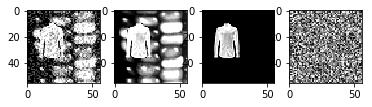

In [8]:
t_batches = DB.gen_test_batches(5,batch_size=512,bg='natural')
b = next(t_batches)

X,Xfg,y = b
w=1
noise_lvl = 0.8
fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),width=1.5,amount=noise_lvl)
noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]

xbg = DB.gen_backgrounds(X,noise_ims)
X_noised = np.clip(X+xbg,-1,1)

fig,axs = plt.subplots(1,4)

for ax,im in zip(axs,[X_noised,X,Xfg,xbg]):
    ax.imshow(im[6].reshape(56,56),cmap='gray')



In [9]:
mod.metrics_names

['loss',
 'Generator_loss',
 'Classifier_loss',
 'Generator_mean_squared_error',
 'Classifier_acc']

In [10]:
X,xfg,y = list(DB.gen_test_batches(1,batch_size=10000,bg='natural'))[0]
X.shape

(10000, 56, 56, 1)

In [11]:
xbgs=[]
for noise_lvl in [0.1,0.9]:
        fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),mode='gaussian',mean=0,var=noise_lvl)
        noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        xbg = DB.gen_backgrounds(X,noise_ims)
        xbgs.append(xbg)
        
X_noised = np.clip(X+xbgs[0],-1,1)

creating noise gaussian({'mean': 0, 'var': 0.1})...
creating noise gaussian({'mean': 0, 'var': 0.9})...


In [12]:
def model_gaussian_noise_sweep(mod,DB,var_levels,n_batches=20,**noise_kws):
    t_batches = list(DB.gen_test_batches(n_batches,batch_size=512,bg='natural'))
    x,_,_ = t_batches[0]
    xbgs = []
    for noise_lvl in var_levels:
        if noise_lvl == 0.0:
            fg_n = np.zeros(shape=(50,512,512,1))
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        else:
            noise_kws['var']=noise_lvl
            fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),**noise_kws)
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        
        xbg = DB.gen_backgrounds(x,noise_ims)
        xbgs.append(xbg)
        
        
    out_recs = []
    for lvl,xbg in zip(var_levels,xbgs):
        print('variance: ',lvl)
        for X,xfg,y in tqdm(t_batches):
            X_noised = np.clip(X+xbg,-1,1)
            Y = {'Generator':xfg,'Classifier':y}

            out = mod.test_on_batch(X_noised,Y)
            out = {k:v for k,v in zip(mod.metrics_names,out)}
            out['width']=w
            out['amount']=lvl
            out_recs.append(out)
            
    fig,axs = plt.subplots(1,len(var_levels))
    
    for ax,xbgs in zip(axs,xbgs):
        noise_ex = np.clip(x+xbgs,-1,1)
        ax.imshow(noise_ex[5].reshape(56,56),cmap='gray')
        
    return pd.DataFrame.from_records(out_recs)

In [13]:
# gaussian_dfs = []
# variances = [0.0,0.5,1,1.5]
# for i, mod in enumerate(load_models(proj_root,exps)):
#     print(exps[i])
#     res_df = model_gaussian_noise_sweep(mod,DB,var_levels=variances,n_batches=20,mode='gaussian',mean=0.0)
#     gaussian_dfs.append(res_df)

In [14]:
# for df,conf in zip(gaussian_dfs,confs):
#     df['Model ID']= conf['id']
#     df['encoder_arch']=conf['encoder_arch']
#     df['recon']=conf['recon_weight']
#     df['baseline_acc']=df[df.amount==0.0]['Classifier_acc'].values.mean()

In [15]:
# gaussian_noise_df = pd.concat(gaussian_dfs)
# gaussian_noise_df['Relative Accuracy']=gaussian_noise_df['Classifier_acc']-gaussian_noise_df['baseline_acc']
# gaussian_noise_df.head()

In [16]:
# sns.barplot(x='Model ID',y='Classifier_acc',data=gaussian_noise_df,hue='amount')

In [17]:
import skimage as skim

In [18]:
def plot_noise_sweep(X_noise,rand_idx=5):
    fig,axs = plt.subplots(1,len(X_noise),figsize=(3*len(X_noise),3))
    for ax,Xn in zip(axs,X_noise):
        ax.imshow(Xn[rand_idx].reshape(56,56),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return fig,axs

In [19]:
noise_sweeps = {
    'speckle':  {'mean':0, 'amount':np.array([0,0.1,0.3,0.6,0.9,1.5])**2},
    'gaussian': {'mean':0, 'amount':np.array([0,0.2,0.3,0.6,0.9,1.5])**2},
    's&p':  {'amount':np.array([0,0.05,0.1,0.2,0.3,0.9])}
}

In [20]:
noise_sweeps['gaussian']['amount']

array([0.  , 0.04, 0.09, 0.36, 0.81, 2.25])

In [21]:
def apply_noise(X, mode, amount, **noise_kws):
    X_out = []
    for amt in amount:
        if mode in ['speckle','gaussian']:
            kws = {'mean':0,'var':amt}
        elif mode in ['salt','pepper','s&p']:
            kws = {'amount':amt}
        
        if amt > 0.0:
            Xn = skim.util.random_noise(X,mode=mode,**kws)
            X_out.append(Xn)
        else:
            X_out.append(X)
        
    return X_out

In [22]:
X_speckle = [X]
for amt in [0.1,0.3,0.6,0.9,1.5]:
    X_n = skim.util.random_noise(X,mode='speckle',mean=0,var=amt**2)
    X_speckle.append(X_n)

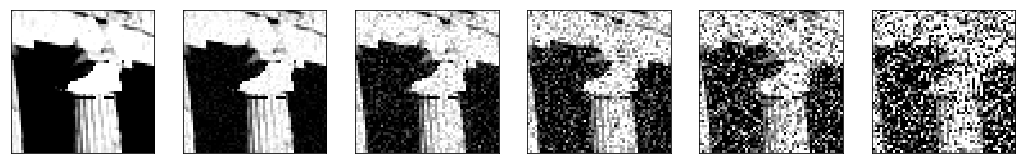

In [35]:
fig,axs = plot_noise_sweep(X_speckle,rand_idx=25)
fig.savefig('../figures/pub/speckle_noise.pdf', dpi=300)

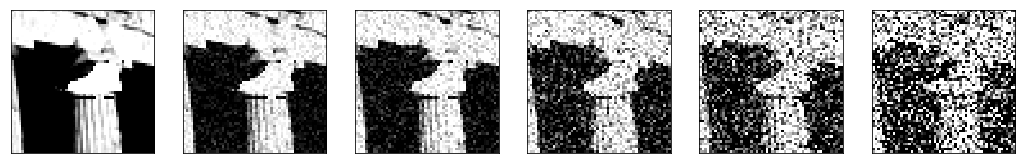

In [36]:
X_gauss = apply_noise(X,mode='gaussian',amount=noise_sweeps['gaussian']['amount'])
fig, axs = plot_noise_sweep(X_gauss,rand_idx=25)
fig.savefig('../figures/pub/gauss_noise.pdf', dpi=300)

[0.   0.05 0.1  0.2  0.3  0.9 ]


(<Figure size 1296x216 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4da9c3f748>,
       dtype=object))

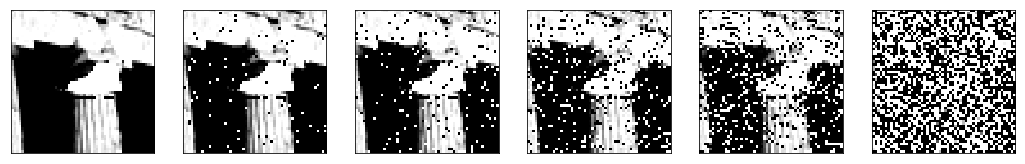

In [33]:
amounts = noise_sweeps['s&p']['amount']
print(amounts)
X_sp = apply_noise(X,mode='s&p',amount=amounts)
fig,axs = plot_noise_sweep(X_sp,rand_idx=25)

In [ ]:
# fig.save_fig('../figures/pub/')

(<Figure size 1296x216 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e0438ab70>,
       dtype=object))

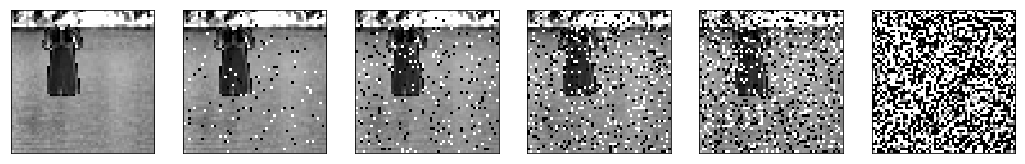

In [26]:
X_sp = [X]
for amt in [0.05,0.1,0.2,0.3,0.9]:
    X_n = skim.util.random_noise(X,mode='s&p',amount=amt)
    X_sp.append(X_n)

plot_noise_sweep(X_sp,rand_idx=20)

In [37]:
def mod_noise_sweep(mod,Xn,batch_sz=512):
    mod_results = []
    Y = {'Generator':xfg,'Classifier':y}
    noise_recs = []
    for XN in Xn:
        out = mod.evaluate(XN,Y,batch_size=batch_sz)
        out = {k:v for k,v in zip(mod.metrics_names,out)}
        noise_recs.append(out)
        
    return pd.DataFrame.from_records(noise_recs)

# speckle_df = mod_noise_sweep(mod,X_speckle)

In [38]:
# speckle_df['type']='speckle'
# speckle_df['amount']=[0,0.1,0.3,0.6,0.9,1.5]

In [41]:
speckle_dfs = []

In [42]:
confs = list(load_config(exps))[2:]
for i,mod in enumerate(load_models(proj_root,exps[2:])):
    print(exps[2:][i])
    conf = confs[i]
    df = mod_noise_sweep(mod,X_speckle,batch_sz=512)
    df['type']='speckle'
    df['amount']=[0,0.1,0.3,0.6,0.9,1.5]
    for k,v in conf.items():
        df[k]=v
    speckle_dfs.append(df)

Compiling model
Experiment(DPX-16)
10000/10000 [==============================] - 1s 136us/step
Compiling model
Experiment(DPX-27)
10000/10000 [==============================] - 1s 133us/step


In [43]:
speck_df = pd.concat(speckle_dfs)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [44]:
gaussian_dfs = []
confs = list(load_config(exps))
for i,mod in enumerate(load_models(proj_root,exps)):
    print(exps[i])
    conf = confs[i]
    df = mod_noise_sweep(mod,X_gauss,batch_sz=512)
    df['type']='gaussian'
    df['amount']=noise_sweeps['gaussian']['amount']
    for k,v in conf.items():
        df[k]=v
    gaussian_dfs.append(df)

Compiling model
Experiment(DPX-29)
10000/10000 [==============================] - 1s 138us/step
Compiling model
Experiment(DPX-30)
10000/10000 [==============================] - 1s 134us/step
Compiling model
Experiment(DPX-16)
10000/10000 [==============================] - 1s 132us/step
Compiling model
Experiment(DPX-27)
10000/10000 [==============================] - 1s 127us/step


In [45]:
gauss_df = pd.concat(gaussian_dfs).reset_index().drop(columns=['index'])
gauss_df['amount']=np.round(gauss_df.amount.values,decimals=2)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [46]:
speck_df = speck_df.reset_index().drop(columns=['index'])

In [47]:
# baseline = lambda x: x[x.amount == 0.0]['Classifier_acc'].values.mean()
# baseline = lambda x: x[x.amount==0]['Classifier_acc'].values.max()
baseline = lambda x: x.max()
# key = lambda x: print(x)

In [49]:
speck_df['baseline_acc']=speck_df.groupby('id')['Classifier_acc'].transform(baseline)
speck_df['Accuracy Change']=speck_df['Classifier_acc']-speck_df.baseline_acc

In [50]:
gauss_df['baseline']=gauss_df.groupby('id')['Classifier_acc'].transform(baseline)
gauss_df['Accuracy Change']=gauss_df['Classifier_acc']-gauss_df.baseline

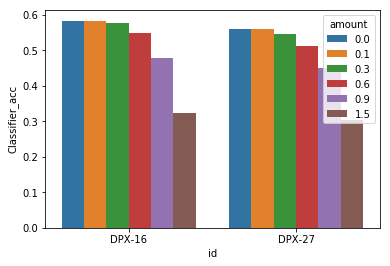

In [51]:
sns.barplot(x='id',y='Classifier_acc',hue='amount',data=speck_df)

In [ ]:
# speck_df.to_pickle('../data/speckle_noise_eval.pk')
# gauss_df.to_pickle('../data/gauss_noise_eval.pk')

(0, -0.6)

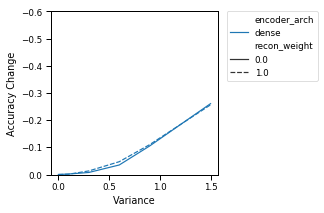

In [52]:
sns.set_context('paper')
fig,axs = plt.subplots(1,1,figsize=(3,3))
sns.lineplot(x='amount',y='Accuracy Change',hue='encoder_arch',style='recon_weight',data=speck_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Variance')
plt.ylim(0,-0.6)

In [ ]:
fig.savefig('../figures/sfn/speckle_noise.pdf',dpi=300)

Text(0.5,0,'Variance')

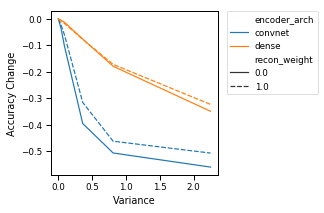

In [55]:
sns.set_context('paper')
fig,axs = plt.subplots(1,1,figsize=(3,3))
sns.lineplot(x='amount',y='Accuracy Change',hue='encoder_arch',style='recon_weight',data=gauss_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Variance')
# plt.ylim(0,-0.6)

In [57]:
fig.savefig('../figures/pub/gauss_noise_inverted.pdf',dpi=300)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


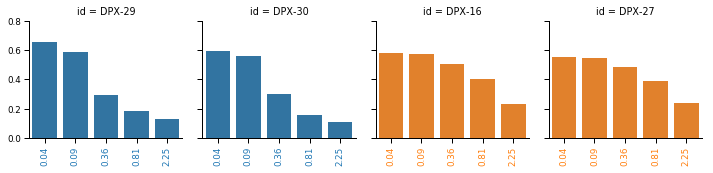

In [54]:
sns.set_context('paper')
g = sns.FacetGrid(col='id',data=gauss_df[gauss_df.amount>0],ylim=(0,0.8),height=2.5,hue='encoder_arch')
g.map(sns.barplot,'amount','Classifier_acc')
g.map(plt.xticks,rotation=90)
# g.map(plt.hlines(y=0.1,xmin=0,xmax=2.25,linestyles='dashed'))
# g.map()
# sns.barplot(x='id',y='Classifier_acc',hue='amount',data=gauss_df)

In [ ]:
g.fig.savefig('../figures/sfn/gauss_noise_bars.pdf',dpi=300)

In [ ]:
sns.set_context('paper')
g = sns.FacetGrid(col='id',data=speck_df[speck_df.amount>0],ylim=(0,0.8),height=2.5,hue='encoder_arch')
g.map(sns.barplot,'amount','Classifier_acc')
g.map(plt.xticks,rotation=90)

In [ ]:
g.fig.savefig('../figures/sfn/speckle_noise_bars.pdf',dpi=300)

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(row='id',data=speck_df,ylim=(0,0.8))
g.map(sns.barplot,'amount','Classifier_acc')
plt.xticks(rotation=90)

In [ ]:
sns.lineplot(x='amount',y='Accuracy Change',hue='encoder_arch',style='recon_weight',data=speck_df)
plt.ylim(0,-0.6)

In [ ]:
confs = list(load_config(exps))
conf = confs[1]

In [ ]:
conf.items()

In [ ]:
# from tqdm.autonotebook import tqdm
def model_noise_sweep(mod,DB,noise_levels,n_batches=20,**noise_kws):
    t_batches = list(DB.gen_test_batches(n_batches,batch_size=512,bg='natural'))
    x,_,_ = t_batches[0]
    xbgs = []
    for noise_lvl in noise_levels:
        if noise_lvl == 0.0:
            fg_n = np.zeros(shape=(50,512,512,1))
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        else:
            fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),**noise_kws)
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        xbg = DB.gen_backgrounds(x,noise_ims)
        xbgs.append(xbg)
        
    out_recs = []
    for lvl,xbg in zip(noise_levels,xbgs):
        print('noise: ',lvl)
        for X,xfg,y in tqdm(t_batches):
            X_noised = np.clip(X+xbg,-1,1)
            Y = {'Generator':xfg,'Classifier':y}

            out = mod.test_on_batch(X_noised,Y)
            out = {k:v for k,v in zip(mod.metrics_names,out)}
            out['width']=w
            out['amount']=lvl
            out_recs.append(out)
    return pd.DataFrame.from_records(out_recs)

In [ ]:
mod_res_dfs = []
for i, mod in enumerate(load_models(proj_root,exps)):
    print(exps[i])
    res_df = model_noise_sweep(mod,DB,noise_levels=[0.0,0.3,0.6,0.9],n_batches=20)
    mod_res_dfs.append(res_df)

In [ ]:
confs = list(load_config(exps))

In [ ]:
for df,conf in zip(mod_res_dfs,confs):
    df['Model ID']= conf['id']
    df['encoder_arch']=conf['encoder_arch']
    df['recon']=conf['recon_weight']
    df['baseline_acc']=df[df.amount==0.0]['Classifier_acc'].values.mean()

In [ ]:
noise_df = pd.concat(mod_res_dfs)
noise_df['Relative Accuracy']=noise_df['Classifier_acc']-noise_df['baseline_acc']
noise_df.head()

In [ ]:
sns.barplot(x='amount',y='Relative Accuracy',hue='encoder_arch',data=noise_df)

In [ ]:
g = sns.FacetGrid(data=noise_df,row='encoder_arch',col='recon',)
g = g.map(sns.lineplot,'amount','Relative Accuracy')

In [ ]:
g = sns.FacetGrid(data=noise_df,row='encoder_arch',col='recon',)
g = g.map(sns.lineplot,'amount','Classifier_acc')

In [ ]:
sns.set_context('talk')
sns.lineplot(x='amount',y='Relative Accuracy',data=noise_df,hue='encoder_arch',style='recon')
plt.ylim(0.0,-0.1)

In [ ]:
sns.set_context('talk')
sns.lineplot(x='amount',y='Classifier_acc',data=noise_df,hue='encoder_arch',style='recon')
# plt.ylim(0.0,-0.1)

In [ ]:
sns.barplot(x='Model ID',y='Relative Accuracy',data=noise_df,hue='amount')

In [ ]:
sns.barplot(x='amount',y='Classifier_acc',data=res_df)

In [ ]:
t_batches = list(DB.gen_test_batches(20,batch_size=512,bg='natural'))

for lvl,xbg in zip(noise_amt,xbgs):
    print('noise: ',lvl)
    for X,xfg,y in t_batches:
        X_noised = np.clip(X+xbg,-1,1)
        Y = {'Generator':xfg,'Classifier':y}
        
        out = mod.test_on_batch(X_noised,Y)
        out = {k:v for k,v in zip(mod.metrics_names,out)}
        out['width']=w
        out['amount']=lvl
        out_recs.append(out)
#         print(out)

In [ ]:
res_df = pd.DataFrame.from_records(out_recs)

In [ ]:
np.median(xbg)

In [ ]:
X_noised = np.clip(X+xbg,-1,1)
plt.imshow(X_noised[6].reshape(56,56),cmap='gray')